# Self-Driving Car Engineer Nanodegree

* **Project: Advanced Lane Line** 

* **Author:   Matt Kontz**

* **Start date:  January 29, 2019**



# Import Packages
Import package to be use throughout project notebook

In [1]:
#importing some useful packages
import os

import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import cv2

%matplotlib inline

# Camera Calibration

## Create list of Calibration Image Files

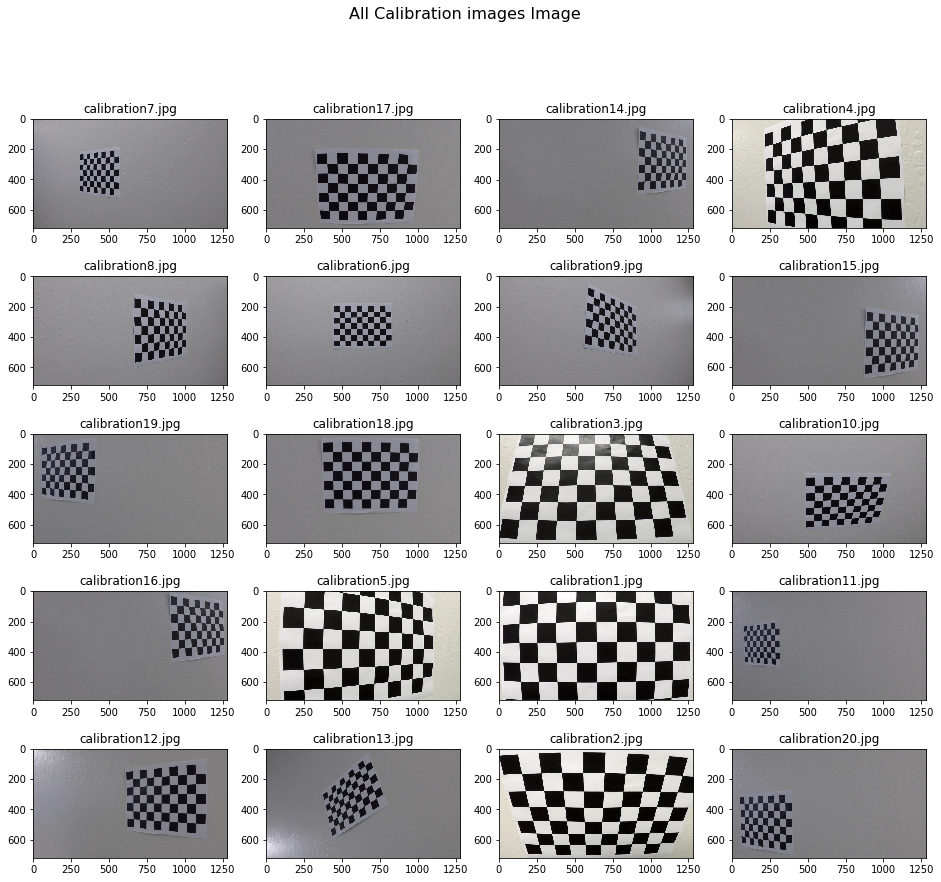

In [2]:
# Find calibration image names 
calImageNames = os.listdir("camera_cal/")

nRow = 5
nCol = 4

fig, ax = plt.subplots(nRow, nCol, figsize=(16, 14))
fig.suptitle("All Calibration images Image", fontsize=16)

for r in range(nRow):    
    for c in range(nCol):
        k = r * nCol + c
        if (k < len(calImageNames)):
            image = mpimg.imread("./camera_cal/" + calImageNames[k])
            ax[r,c].imshow(image)
            ax[r,c].set_title(calImageNames[k])

fig.savefig('output_images/cal_images.png')


## Create List of Image and Object Points for Camera Calibration

* Create empty lists for object and image points
* Create object points once as this will be the same for all images
* Iterate through calibration images
    * load image
    * convert to grey scale
    * find corners (i.e. image points) using findChessboardCorners
    * if success append image and object points to list
    
Notice that several of the images fail to produce image points as shown in the plot below.  This appears to because some of the corners on the images that failed are not included in the image.

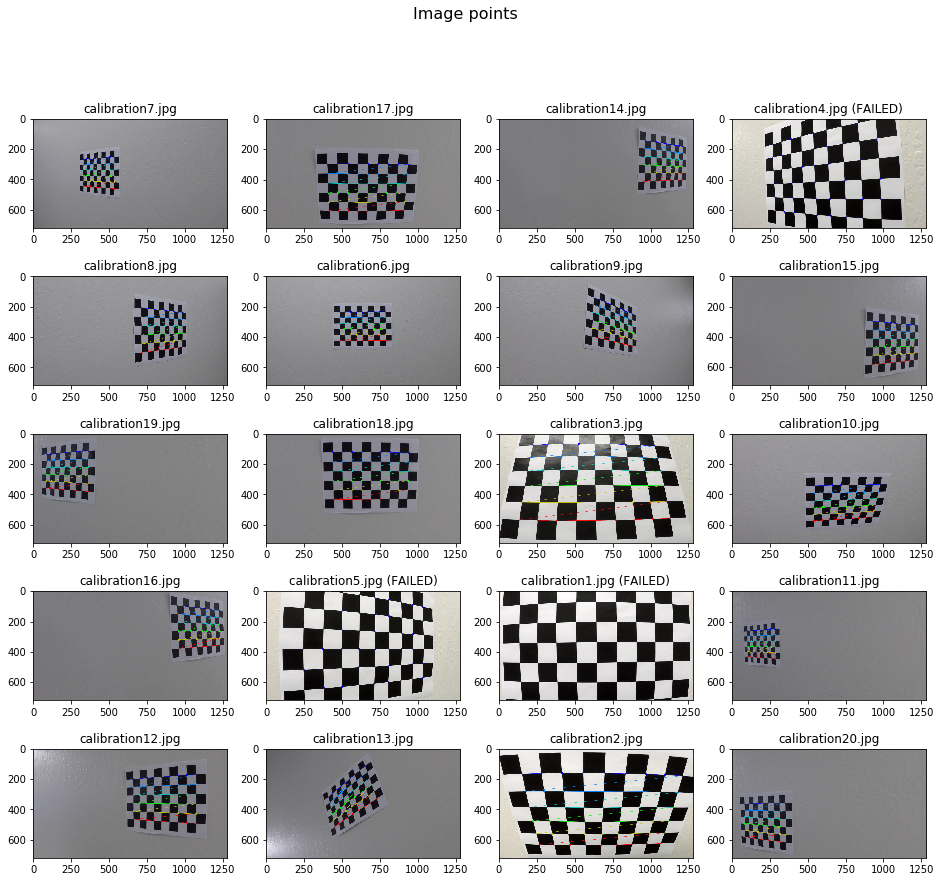

In [3]:
imgpoints = []
objpoints = []

objpnt = np.zeros((6*9,3), np.float32)
objpnt[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Create figure to plot image points on calibration images
nRow = 5
nCol = 4
fig, ax = plt.subplots(nRow, nCol, figsize=(16, 14))
fig.suptitle("Image points", fontsize=16)

for k in range(len(calImageNames)):
    fname = calImageNames[k]
    
    # load a calibration image
    raw_img = mpimg.imread("./camera_cal/" + fname)
    raw_plot = plt.imshow(raw_img)

    # convert to gray scale image
    gray = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    if ret:
        # if points are found then append to list of image and object points
        imgpoints.append(corners)
        objpoints.append(objpnt)
        
    c = int(k % nCol)
    r = int((k - c) / nCol)
    corner_lines_img = cv2.drawChessboardCorners(raw_img, (9, 6), corners, ret)
    ax[r,c].imshow(corner_lines_img)
    if ret:
        ax[r,c].set_title(calImageNames[k])
    else:
        ax[r,c].set_title(calImageNames[k] + ' (FAILED)')

fig.savefig('output_images/cal_image_points.png')
    
    
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


# Distortion Correction

The camera calibration calculated five parameters
 
* ret - (return value) boolean that indicates success
* mtx - (camera matrix) 
    * focal length = ( f<sub>x</sub> f<sub>y</sub> )
    * optical centers = ( c<sub>x</sub> c<sub>y</sub> )
\begin{equation*}
    mtx = \left( 
        \begin{matrix}
        f_x & 0 & c _x\\
        0 & f_y & c_y \\
        0 & 0 & 1 \\
    \end{matrix} \right)
\end{equation*}

* dist - (distortion coefficients)
\begin{equation*} 
    dist = \left[ k_1 k_2 p_1 p_2 k_3 \right] 
\end{equation*}
* rvecs - (rotation vectors) 
* tvecs - (translation vectors)

The two calibration parameters required for removing distortion are the camera martix (mtx) and distortion coefficients (dist) to produce an undistorted image.  These two parameters along with the original image are fed into cv2.undistort().  These to parameter and cv2.undistort() will be used throughout this project.  See sample below.


## Undistort function
This function takes the distorted image and returns the undistorted image.

In [4]:
def Undistort(image):
    # undistort image
    return cv2.undistort(image, mtx, dist, None, mtx)

## Verify Calibration on Sample Image
The test image is actually one of the image that failed to be added to the calibration set because not all the corners are include in the image.  There are only (9 x 5) corners instead of (9 x 6) corners.  Since this test image is straight on and zoomed in it clearly shows distortion correction because all the boxes and lines are straight in the undistorted image.

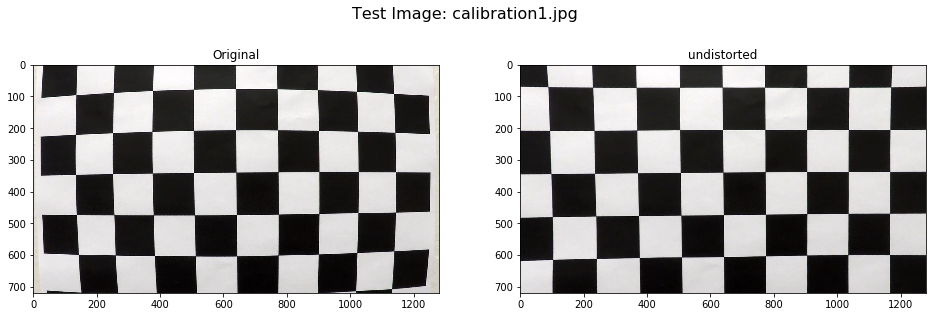

In [5]:
# load and plot Sample image
fname = 'calibration1.jpg'
sample_img = mpimg.imread("./camera_cal/" + fname)

dst = Undistort(sample_img)

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Test Image: " + fname, fontsize=16)

ax[0].imshow(sample_img)
ax[0].set_title('Original')
    
ax[1].imshow(dst)
ax[1].set_title('undistorted')

fig.savefig('output_images/undistorted_chessboard.png')


# Color/Gradient Threshold

In [15]:

def ColorThreshold(dst_img, s_thresh = (170, 255)):
    # convert to HLS (hue, lightness, and saturation) color space
    HLS_img = cv2.cvtColor(dst_img, cv2.COLOR_RGB2HLS)
    
    # select saturation channel
    S = HLS_img[:,:,2]
    
    binary_output = np.zeros_like(S)
    binary_output[(s_thresh[0] < S) & (S <= s_thresh[1])] = 1

    return binary_output

def GrayGradTheshold(dst_img, sx_thresh = (20, 200)):
    #convert to gray scale image
    gray = cv2.cvtColor(dst_img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    binary_output = np.zeros_like(scaled_sobelx)
    binary_output[(sx_thresh[0] < scaled_sobelx) & (scaled_sobelx <= sx_thresh[1])] = 1

    return binary_output

def ColarGradientThreshold(dst_img, s_thresh = (170, 255), sx_thresh = (20, 255)):
    color_th_img = ColorThreshold(dst_img, s_thresh = (170, 255))   
    grad_th_img = GrayGradTheshold(dst_img, sx_thresh = (20, 200))
    
    return np.bitwise_or(color_th_img, grad_th_img)

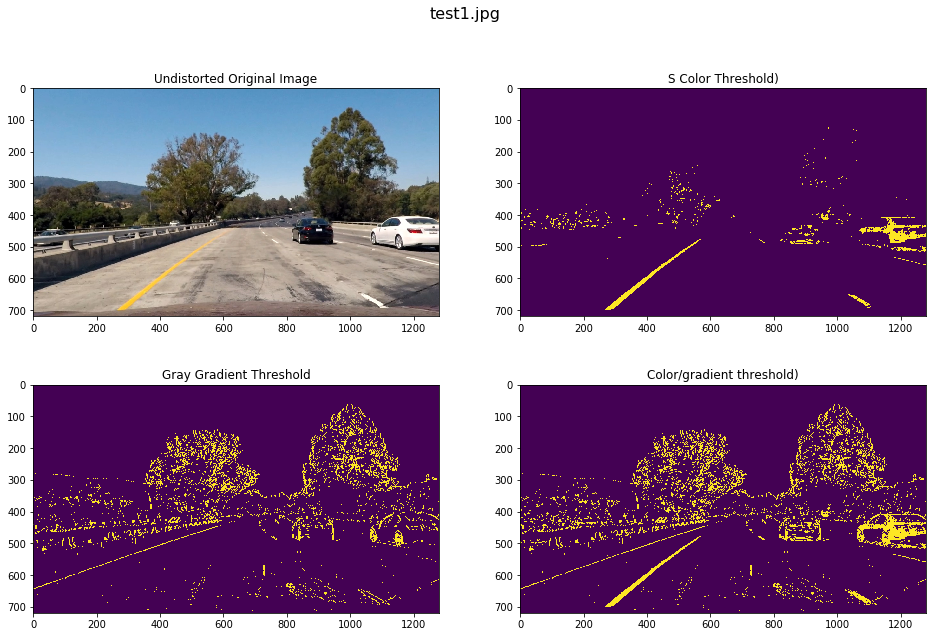

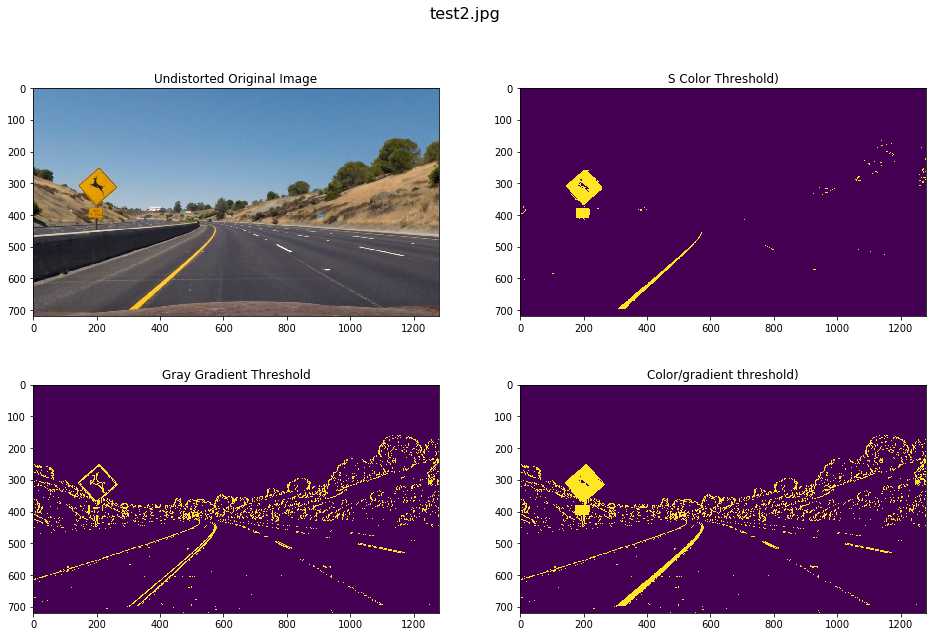

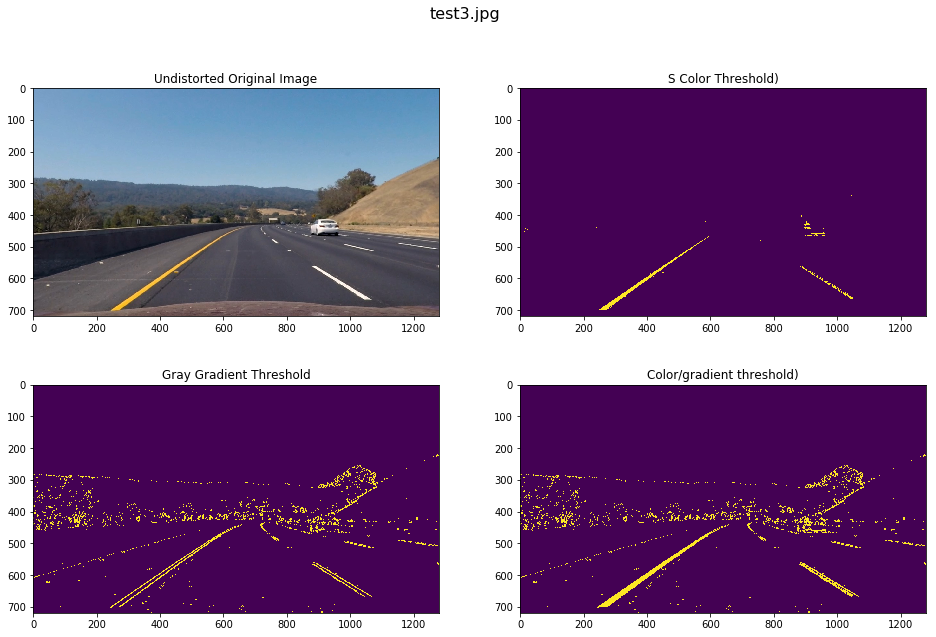

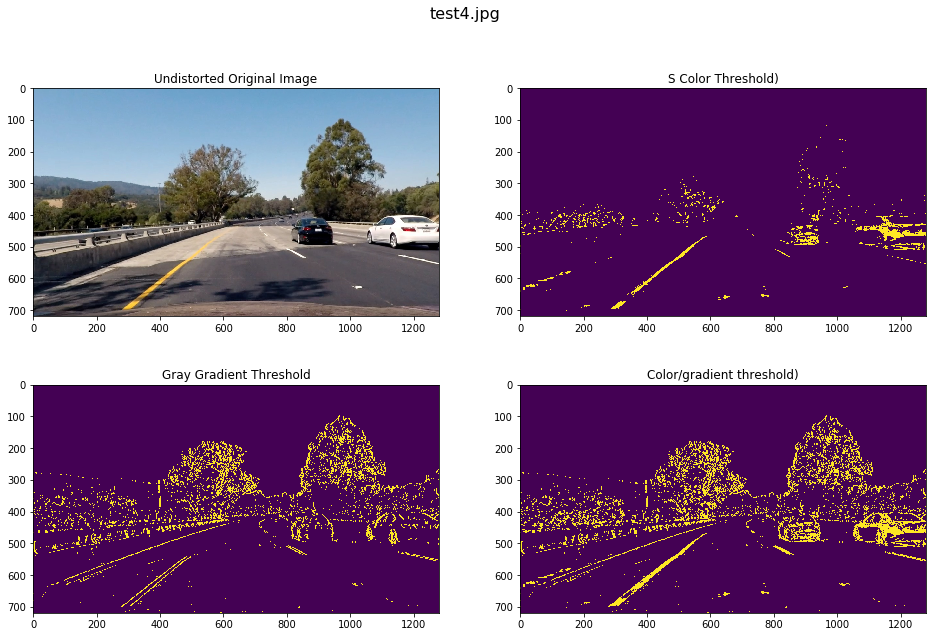

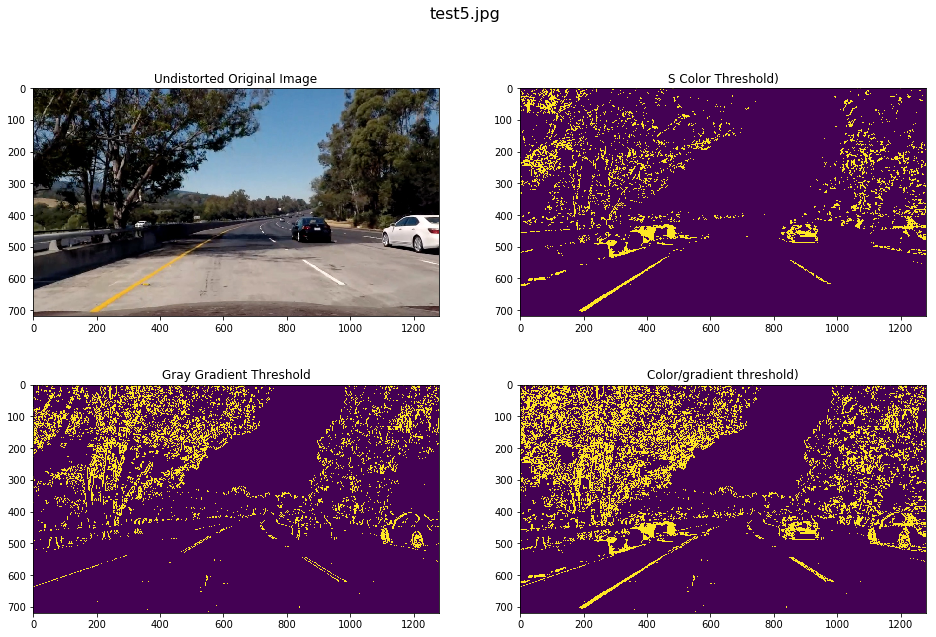

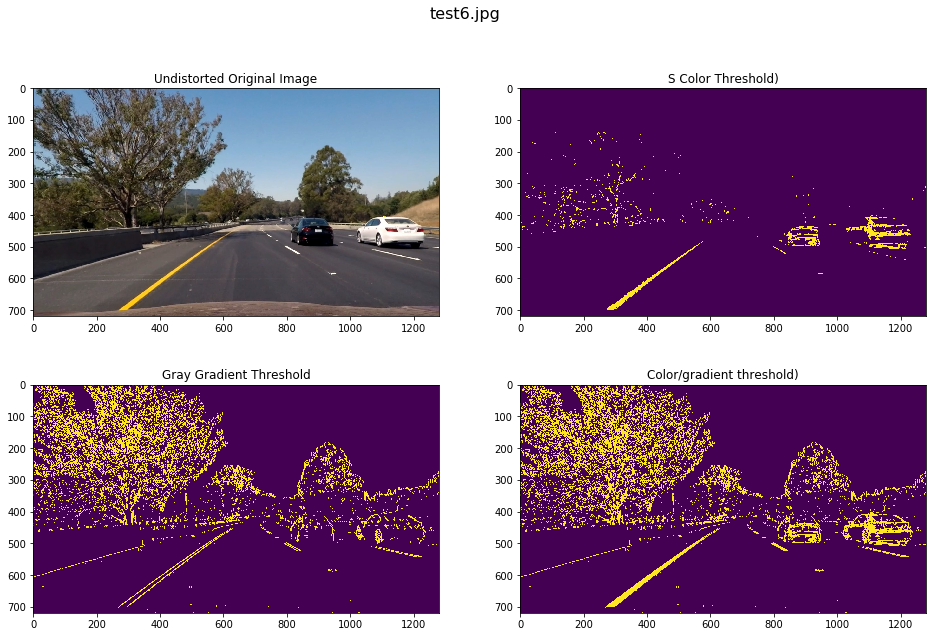

In [16]:

for k in range(1,7):
    # load test image
    fname = 'test' + str(k) + '.jpg'
    raw_img = mpimg.imread('test_images/' + fname)
    
    dst = cv2.undistort(raw_img, mtx, dist, None, mtx)
    
    color_th_img = ColorThreshold(dst, s_thresh = (170, 255))
    
    grad_th_img = GrayGradTheshold(dst, sx_thresh = (20, 200))

    color_grad_im = ColarGradientThreshold(dst, s_thresh = (170, 255), sx_thresh = (20, 200)) 
    
    fig, ax = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(fname, fontsize=16)
    
    ax[0, 0].imshow(dst)
    ax[0, 0].set_title('Undistorted Original Image')

    ax[0, 1].imshow(color_th_img)
    ax[0, 1].set_title('S Color Threshold)')
    
    ax[1, 0].imshow(grad_th_img)
    ax[1, 0].set_title('Gray Gradient Threshold')

    ax[1, 1].imshow(color_grad_im)
    ax[1, 1].set_title('Color/gradient threshold)')
    
    fig.savefig('output_images/' + fname[:-4] + '_out.png')

# Perspective Transform

In [17]:
def drawPolygonLines(img, pnts, color = (50, 200, 50), thickness = 10):
    # Create black image the same size as img to draw the lines on
    poly_line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    cv2.polylines(poly_line_img, [pnts], False, color, thickness)
    
    return poly_line_img
    
def drawPolygonFill(img, pnts, color = (50, 200, 50)):
    # Create black image the same size as img to draw the polygon shape
    poly_fill_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    cv2.fillPoly(poly_fill_img, np.int_([pnts]), color)
    
    return poly_fill_img

#   from Project 1
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def perspective2flat(image_in, M):
    # use cv2.warpPerspective() to warp your image to a top-down view
    return cv2.warpPerspective(image_in, M, image_in.shape[1::-1], flags=cv2.INTER_LINEAR)


(720, 1280, 3)
(720, 1280, 3)


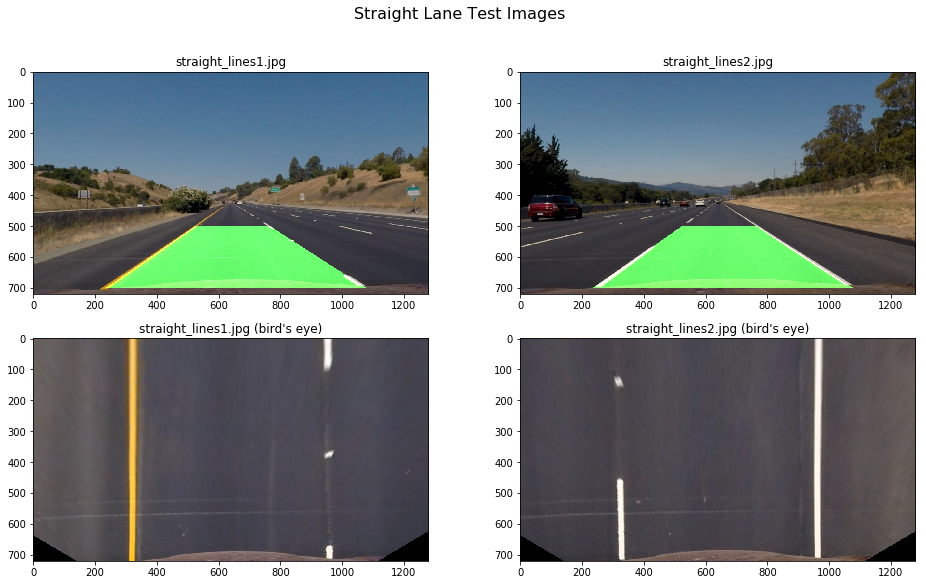

In [18]:
# points in pixels defining polygon to draw on images
pnts = np.array([[235, 700], [525, 500], [765, 500], [1075, 700]])
src_pnts = np.float32(pnts)
dx_m = 3.7 # approximate lane width (m)
dy_m = 30. # approimate distance to source points (m)
dx_px = 640.
dy_px = 719.
x_offset = 320.
dst_pnts = np.float32([[x_offset, dy_px], [x_offset, 0.], [x_offset + dx_px, 0.], [x_offset + dx_px, dy_px]])

# use cv2.getPerspectiveTransform() to get M, the transform matrix
Mpersp = cv2.getPerspectiveTransform(src_pnts, dst_pnts) 

fig, ax = plt.subplots(2, 2, figsize=(16, 9))
fig.suptitle('Straight Lane Test Images', fontsize=16)

for k in range(1,3):
    # load test image
    fname = 'straight_lines' + str(k) + '.jpg'
    raw_img = mpimg.imread('test_images/' + fname)
    
    dst = Undistort(raw_img)
    print(dst.shape)
    
    polylines = drawPolygonLines(dst, pnts)
    polyfill = drawPolygonFill(dst, pnts)
    overlay_image = weighted_img(polyfill, dst)

    flat_img = perspective2flat(dst, Mpersp)

    ax[0, k-1].imshow(overlay_image)
    ax[0, k-1].set_title(fname)
    
    ax[1, k-1].imshow(flat_img)
    ax[1, k-1].set_title(fname + " (bird's eye)")

fig.savefig('output_images/perspective_Transform.png')

# Detect Lane Lines

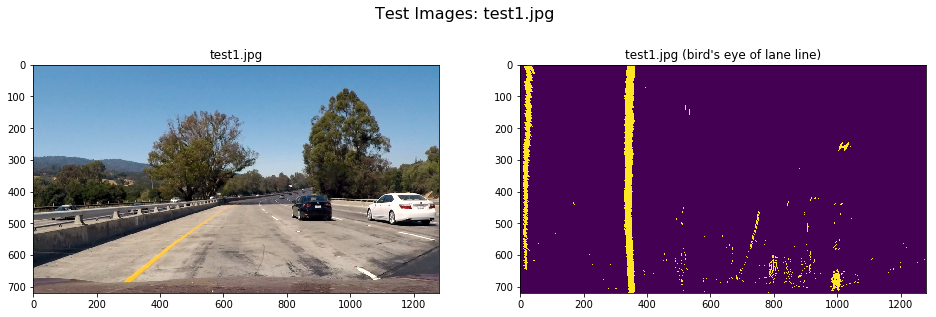

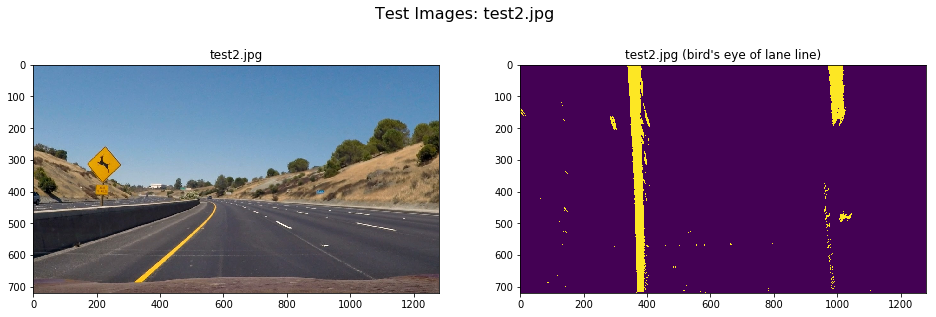

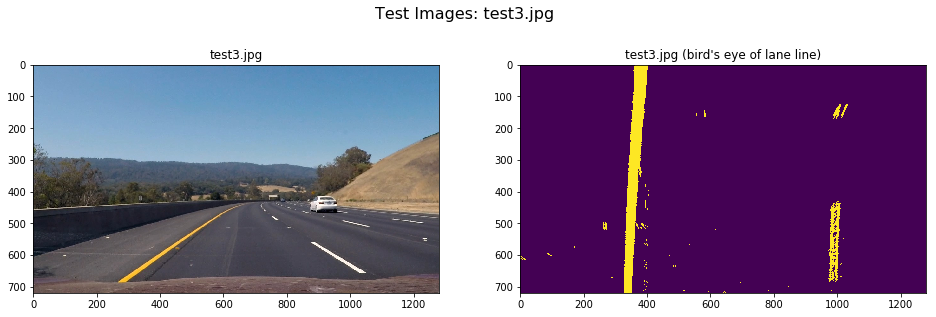

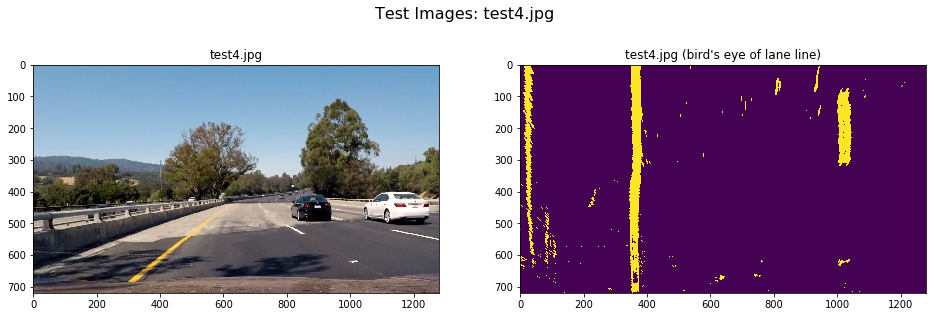

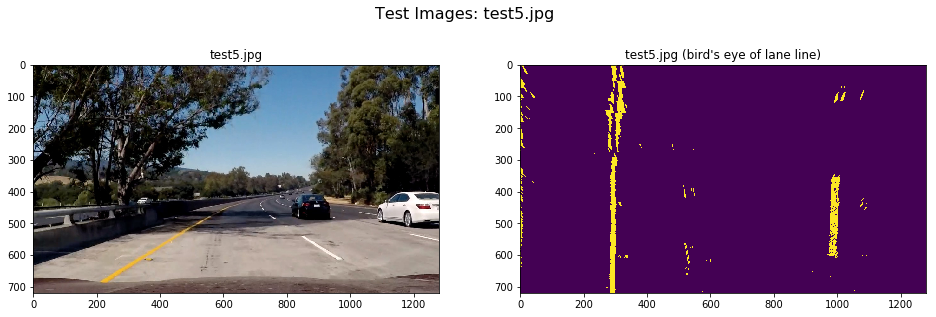

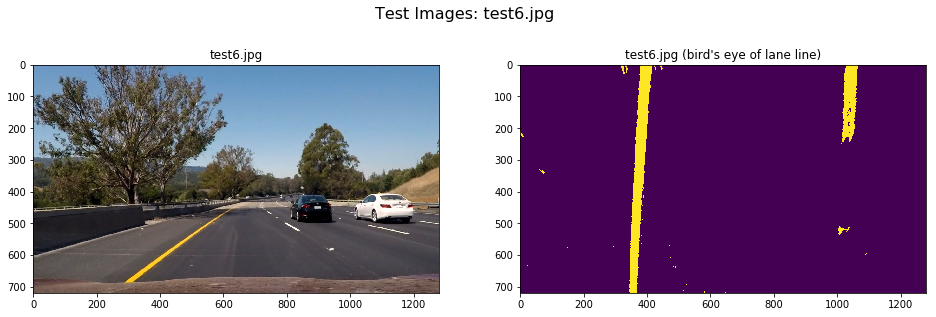

In [21]:
def binaryLaneLinesPipe(img):
    # undistort image
    dst_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # apply color and gradient thresholds
    color_grad_img = ColarGradientThreshold(dst_img, s_thresh = (170, 255), sx_thresh = (20, 200)) 
    
    # warp image with perspective transfrom
    return perspective2flat(color_grad_img, Mpersp)


for k in range(1,7):
    # load test image
    fname = 'test' + str(k) + '.jpg'
    raw_img = mpimg.imread('test_images/' + fname)
    
    flat_lanes = binaryLaneLinesPipe(raw_img)
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    fig.suptitle('Test Images: ' + fname, fontsize=16)
    
    ax[0].imshow(raw_img)
    ax[0].set_title(fname)
    
    ax[1].imshow(flat_lanes)
    ax[1].set_title(fname + " (bird's eye of lane line)")
    
    

# Determine the Lane Curvature

# Play Video